# STAN48 Programming for Data Science - R

## Final project

As a conclusion to this course I decided to create simple implementation of a feed forward neural network using mainly Numpy and base Python. While there are already exquisite packages that offer these solutions (like Tensorflow and Pytorch), a step by step implementation of a neural network is still valuable for teaching basic programming concepts as well as basic neural network concepts. The code and explanations presented here are inspired heavily from two sources, namely Andrew Ng's course on [Neural Networks and Deep Learning](https://www.coursera.org/learn/neural-networks-deep-learning?specialization=deep-learning), and LUSEM's [Deep Learning and AI Methods](https://www.stat.lu.se/utbildning/kurser/stan47_deep_learning_and_artificial_intelligence_methods) course. The code is then an adaptation of the teachings found in both courses. Additionally, in this project I offer an R version for the project presented here, which can be found in the `R-NN_from_scratch.ipynb` file. As a final disclaimer I must admit that adapting the code in Python was not a hard task, but porting it to R was a strenuous nightmare-like task since the data types can be treated quite differently in both R and Python.

As a general example I will use the [Kaggle Dogs vs. Cats](https://www.microsoft.com/en-us/download/details.aspx?id=54765) dataset to classify whether a given picture shows a cat or not. As the data set only includes two different options, we can assume the `not cat` option to be the same as `dog`. As mentioned, the intent is to have a general example to expose how the algorithm works, and the intricasies of the programming challenge, in other words, it is *not* my intention to implement a functioning neural network from scratch **and** a good model for classifying cats. 

## R or Python?

This notebook is originally made for Python. One of the requirements for this project was that whatever the choice of application to be developed, it should be done in both Python **and** R. Being that so, this notebook will focus on porting the Python code to R, and therefore, I will not bother in copy pasting the exact same explanations about the data or what a Neural Network is. For that purpose I urge the reader to check the Python notebook with the same name as this one. 

One practical element of this choice is that at times you will be met with cells starting with `%%writefile`, in those cases one should change the kernel of the notebook (since this command is native to IPyKernel, not R). All else should run smoothly through R.

### The structure

This project include several files. In this notebook you will find the application related functions, however, many of the base functions used for the calculations are left in a separate file that concentrates all the basic calculation functions. Without those dependencies this notebook will not function as it should. Some basic concepts regarding neural networks will be presented through the notebook, but the focus of this work is exposing the programming challenge behind neural networks.

### The data

The data set contains 25000 images of dogs and cats, but 59 of them were corrupted or in grayscale and, therefore, dropped. The classes are balanced and the angle, depth, light, and dimensions are not uniform. While originally a Kaggle competition data set, I opted to use the version made available by Microsoft because it did not pre divide the data giving me more freedom to split the sets as I please.

In [1]:
%%writefile helper_functions.R
#one could potentially use the `sigmoid` library for the relu and sigmoid functions, but they are very simple to implement too.
relu<-function(Z){
  A<-pmax(Z,0)
  cache<-Z
  return(list(A,cache))
}
sigmoid<-function(Z){
  A<-1/(1+exp(Z))
  cache<-Z
  return(list(A,cache))
}
relu_backprop<-function(dA, cache){
  Z=cache
  dZ<-dA
  dZ[Z<=0]<-0
  return(dZ)
}
sigmoid_backprop<-function(dA,cache){
  Z<-cache
  s<-1/(1+exp(-Z))
  dZ<-dA*s*(1-s)
  return(dZ)
}

Overwriting helper_functions.R


In [2]:
%%writefile init_param.R
fill.matrix<-function(expr,nrow=1,ncol=1){
  matrix(eval(expr,envir=list(x=nrow*ncol)),nrow=nrow,ncol=ncol)
}
init_param<-function(layer_dim){
  L<-length(layer_dim)
  parameters=vector("list",0)
  for (l in 1:(L-1)){
    n=layer_dim[l]*layer_dim[l+1]
    parameters[[paste0("W",l)]]<-fill.matrix(rnorm(n=n)*0.01,nrow=layer_dim[l+1],ncol=layer_dim[l])
    parameters[[paste0("b",l)]]<-matrix(0,layer_dim[l+1],1)
  }
  return(parameters)
}

Overwriting init_param.R


In [3]:
%%writefile for_prop.R
source("helper_functions.R")
for_prop<-function(A,W,b){
  Z<-sweep((W%*%A),MARGIN=1,STATS=b,FUN="+")
  cache<-list(A,W,b)
  return(list(Z,cache))
}
for_activation<-function(A_prev,W,b,activ){
  if(activ=='sigmoid'){
    calc<-for_prop(A_prev,W,b)
    Z<-calc[[1]]
    linear_cache<-calc[[2]]
    calc2<-sigmoid(Z)
    A<-calc2[[1]]
    activ_cache<-calc2[[2]]
  } else if (activ=='relu'){
    calc<-for_prop(A_prev,W,b)
    Z<-calc[[1]]
    linear_cache<-calc[[2]]
    calc2<-relu(Z)
    A<-calc2[[1]]
    activ_cache<-calc2[[2]]
  }
  cache=list(linear_cache,activ_cache)
  return(list(A,cache))
}

Overwriting for_prop.R


In [4]:
%%writefile deep_model.R
source("for_prop.R")
deep_model<-function(X,parameters){
  caches<-list()
  A<-X
  L<-length(parameters)%/%2
  for (l in 1:(L)){
    if (l==L){
      A_prev<-A
      calc<-for_activation(A_prev,parameters[[paste0("W",L)]],parameters[[paste0("b",L)]],activ='sigmoid')
      AV<-calc[[1]]
      cache<-calc[[2]]
      caches[l]<-list(cache)
    } else {
    A_prev<-A
    calc<-for_activation(A_prev,parameters[[paste0("W",l)]],parameters[[paste0("b",l)]],activ='relu')
    A<-calc[[1]]
    cache<-calc[[2]]
    caches[l]<-list(cache)
    }
  }
  return(list(AV,caches))
}

Overwriting deep_model.R


In [5]:
%%writefile cost_computation.R
cost_computation<-function(AV,Y){
  m<-length(Y)
  cost=-(1/m)*sum(log(AV)%*%Y+log((1-AV))%*%(1-Y))
  cost<-unlist(cost)
  return(cost)
}

Overwriting cost_computation.R


In [6]:
%%writefile back_prop.R
source("helper_functions.R")
back_prop<-function(dZ,cache){
  A_prev<-cache[[1]]
  W<-cache[[2]]
  b<-cache[[3]]
  m<-dim(A_prev)[2]
  dW<-(1/m)*(dZ%*%t(A_prev))
  db<-(1/m)*sum(dZ)
  dA_prev<-t(W)%*%dZ
  return(list(dA_prev,dW,db))
}
back_activ<-function(dA,cache,activ){
  for_cache<-cache[[1]][[1]]
  activ_cache<-cache[[1]][[2]]
  if (activ=='relu'){
    dZ<-relu_backprop(dA[[1]],activ_cache)
    calc<-back_prop(dZ,for_cache)
    dA_prev<-as.matrix(calc[[1]])
    dW<-calc[[2]]
    db<-calc[[3]]
  } else if (activ=='sigmoid'){
    dZ<-sigmoid_backprop(dA,activ_cache)
    calc<-back_prop(dZ,for_cache)
    dA_prev<-calc[[1]]
    dW<-calc[[2]]
    db<-calc[[3]]
  }
  return(list(dA_prev,dW,db))
}
deep_model_back<-function(AV,Y,caches){
  grads<-list()
  L<-length(caches)
  m<-dim(AV)[2]
  Y<-matrix(Y, nrow=1, ncol=length(AV))
  dAL=-(Y/AV)-((1-Y)/(1-AV))
  present_cache<-caches[L]
  calc<-back_activ(dAL,present_cache,activ='sigmoid')
  grads[paste("dA",L,sep="")]<-list(calc[[1]])
  grads[paste("dW",L,sep="")]<-list(calc[[2]])
  grads[paste('db',L,sep="")]<-list(calc[[3]])
  for (l in (L-1):1){
    present_cache<-caches[l]
    calcul<-back_activ(grads[paste0("dA",l+1)],present_cache,activ='relu')
    dA_prev_temp<-calcul[[1]]
    dW_temp<-calcul[[2]]
    db_temp<-calcul[[3]]
    grads[paste0('dA',l)]<-list(dA_prev_temp)
    grads[paste0('dW',l)]<-list(dW_temp)
    grads[paste0('db',l)]<-list(db_temp)
  }
  return(grads)
}

Overwriting back_prop.R


In [7]:
%%writefile update.R
update<-function(params,grads,learning_rate){
  parameters<-params
  L<-length(parameters)%/%2
  for (l in 1:L){
    parameters[[paste0("W",l+1)]]<-parameters[[paste0("W",l+1)]]-learning_rate*grads[[paste0('dW',l+1)]]
    parameters[[paste0("b",l+1)]]<-parameters[[paste0("b",l+1)]]-learning_rate*grads[[paste0('db',l+1)]]
  }
  return(parameters)
}

Overwriting update.R


In [8]:
%%writefile create_dataset.R
library(imager)
load <- function(im){
  skip_to_next<-FALSE
  tryCatch(load.image(im), error = function(e){skip_to_next<<-TRUE},
           if(skip_to_next){next})
}
clean_set<-function(loaded_images){
  for(i in 1:length(loaded_images)){
    error_check<-FALSE
    tryCatch(if(dim(loaded_images[[i]])[4]!=3){
      loaded_images <- loaded_images[-i]
    }, error=function(e){error_check<<-TRUE},
    if(error_check){loaded_images=loaded_images[-i]})
    tryCatch(if(dim(loaded_images[[i]])[4]==3){ 
      next},error=function(e){error_check<<-TRUE},
      if(error_check){loaded_images=loaded_images[-i]})
    tryCatch(if(loaded_images[[i]]==1){
      loaded_images <- loaded_images[-1]
    }, error=function(e){error_check<<-TRUE},
    if(error_check){next})
  }
  return(loaded_images)
}
resize_set<-function(loaded_images,width,height){
  for(i in 1:length(loaded_images)){
    loaded_images[[i]]<-resize(loaded_images[[i]],width,height,interpolation_type=1)
  }
  loaded_images<-do.call("cbind",loaded_images)
  return(loaded_images)
}
create_dataset<-function(filenames_cat,filenames_dog, labels=c(1,0),width,height){
  loaded_cats<-sapply(filenames_cat,FUN=load,USE.NAMES=TRUE)
  names(loaded_cats)<-gsub("C:/Users/wtrindad/source/repos/NN_from_scratch/PetImages/","",names(loaded_cats))
  plot(loaded_cats$`Cat/1.jpg`)
  loaded_cats<-clean_set(loaded_cats)
  loaded_cats<-resize_set(loaded_cats,width,height)
  cat_labels<-rep(labels[1],dim(loaded_cats)[2])
  plot(as.cimg(loaded_cats[,2],x=32,y=32,z=1,cc=3))
  loaded_dogs<-sapply(filenames_dog,FUN=load,USE.NAMES=TRUE)
  names(loaded_dogs)<-gsub("C:/Users/wtrindad/source/repos/NN_from_scratch/PetImages/","",names(loaded_dogs))
  plot(loaded_dogs$`Dog/1.jpg`)
  loaded_dogs<-clean_set(loaded_dogs)
  loaded_dogs<-resize_set(loaded_dogs,width=32,height=32)
  dog_labels<-rep(labels[2],dim(loaded_dogs)[2])
  plot(as.cimg(loaded_dogs[,2],x=32,y=32,z=1,cc=3))
  dataset<-cbind(loaded_cats,loaded_dogs)
  labels<-append(cat_labels,dog_labels)
  return(list(dataset,labels))
}

Overwriting create_dataset.R


In [9]:
%%writefile dense_nn.R
source("update.R")
source("back_prop.R")
source("deep_model.R")
source("init_param.R")
source("cost_computation.R")
dense_nn<-function(X,Y,layers_dims,learning_rate=0.0075,num_iterations=5000,print_cost=FALSE){
  costs<-list()
  parameters<-init_param(layers_dims)
  for(i in 1:num_iterations){
    calc<-deep_model(X,parameters)
    AV<-calc[[1]]
    caches<-calc[[2]]
    cost<-cost_computation(AV,Y)
    grads<-deep_model_back(AV,Y,caches)
    parameters<-update(parameters,grads,learning_rate)
    if(print_cost && i%%100==0 | i==num_iterations-1){
      print("Cost after iteration ",i,": ",cost)
    }
    if(i%%100==0 | i==num_iterations){
      costs<-append(costs,cost)
    }
  }
  return(list(parameters,costs))
}

Overwriting dense_nn.R


In [10]:
%%writefile predict.R
source("deep_model.R")
predict<-function(X,y,parameters){
    m<-dim(X)[2]
    n<-length(parameters)%/%2
    p<-matrix(0,1,m)
    dm<-deep_model(X,parameters)
    probs<-dm[[1]]
    caches<-dm[[2]]
    for (i in 1:dim(probs)[2]){
        if(probs[1,i]>0.5){
            p[1,i]=1
        } else {
            p[1,i]=0
        }
    }
    print("Accuracy ", sum((p==y)/m))
    return(p)
}

Overwriting predict.R


Loading required package: magrittr


Attaching package: 'imager'


The following object is masked from 'package:magrittr':

    add


The following objects are masked from 'package:stats':

    convolve, spectrum


The following object is masked from 'package:graphics':

    frame


The following object is masked from 'package:base':

    save.image




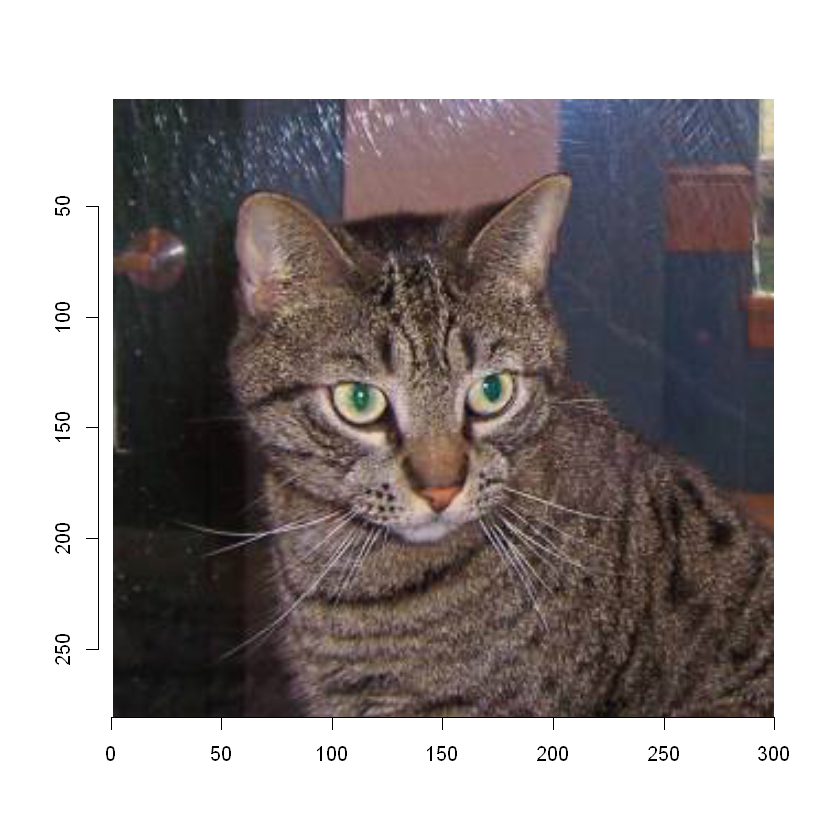

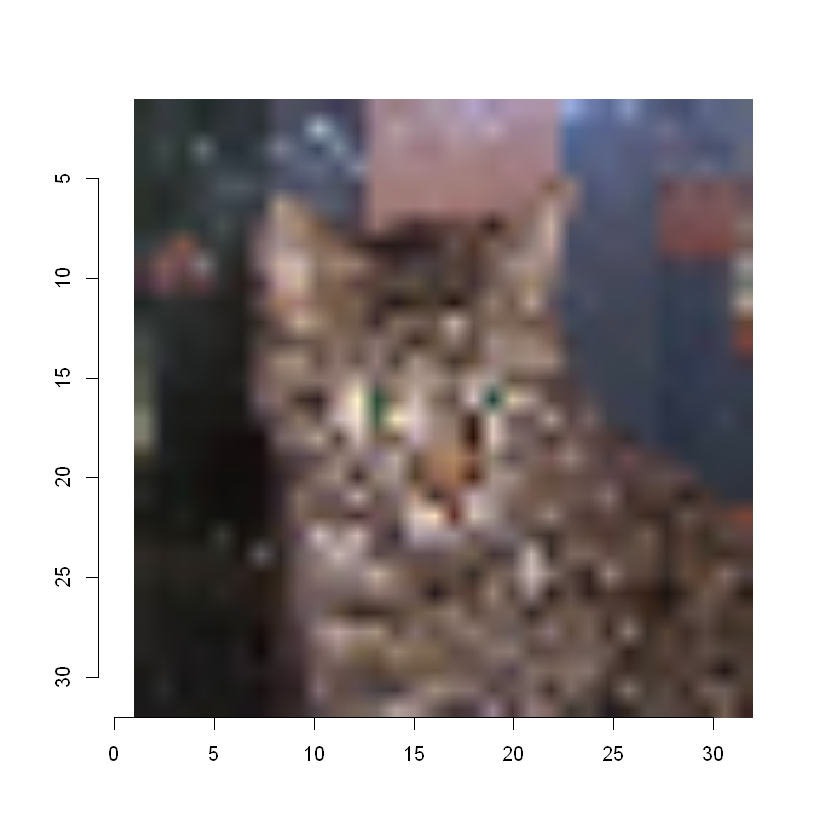

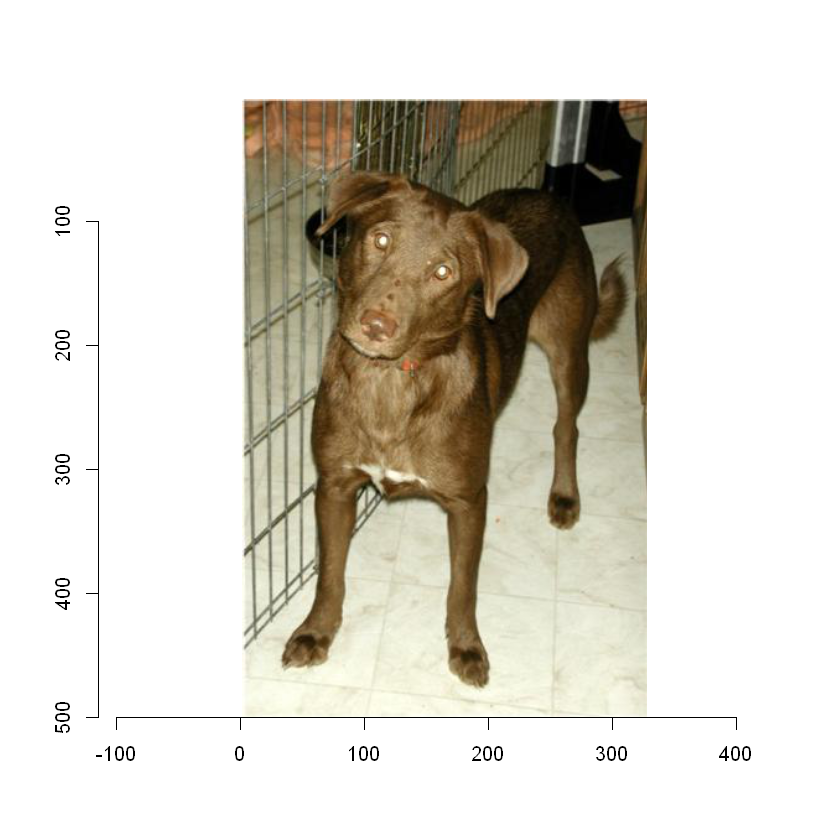

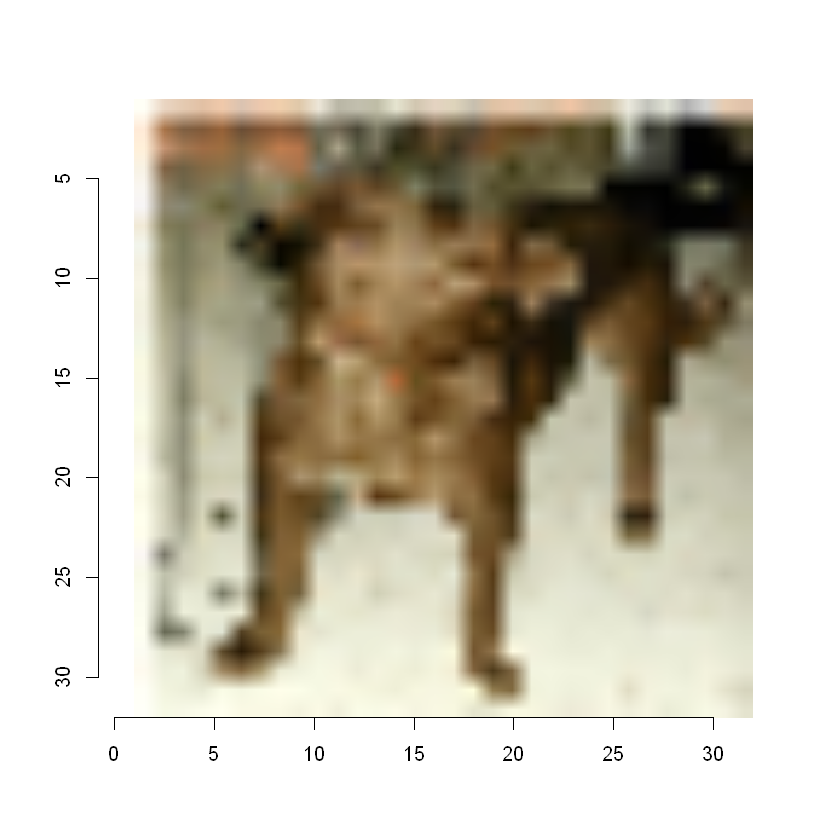

In [1]:
source("create_dataset.R")
filenames_cat <- list.files("C:/Users/wtrindad/source/repos/NN_from_scratch/PetImages/Cat/", pattern="*.jpg", full.names=T)
filenames_dog <- list.files("C:/Users/wtrindad/source/repos/NN_from_scratch/PetImages/Dog/", pattern="*.jpg", full.names=T)
img_data<-create_dataset(filenames_cat,filenames_dog,labels=c(1,0),width=32,height=32) # Do notice this cell will take a good 
                                                                                       # 15min or more to run, more if your computer 
                                                                                       # is below average. As it progresses it will 
                                                                                       # plot different images, you can use these as 
                                                                                       # reference of what stage of the calculation
                                                                                       # the function is at. Also to see cute animals
                                                                                        

In [2]:
dataset<-img_data[[1]]
labels<-img_data[[2]]

samples<-sample(c(TRUE,FALSE),ncol(dataset),replace=TRUE,prob=c(0.85,0.15))

x_train<-dataset[,samples]
y_train<-labels[samples]
x_test<-dataset[,!samples]
y_test<-labels[!samples]

In [3]:
dim(x_train)
length(y_train)
dim(x_test)
length(y_test)

[1]  3072 21147

[1] 21147

[1] 3072 3779

[1] 3779

In [4]:
layer_dims<-c(dim(x_train)[1],20,7,5,1)

In [5]:
source("dense_nn.R")
short_run<-dense_nn(x_train,y_train,layer_dims,learning_rate=0.3,num_iterations=1,print_cost=TRUE)
parameters<-short_run[[1]]
costs<-short_run[[2]]
print(costs)

In [6]:
long_run<-dense_nn(x_train,y_train,layer_dims,learning_rate=0.3,num_iterations=150,print_cost=TRUE)
parameters<-long_run[[1]]
costs<-long_run[[2]]

Warning message in matrix(Y, nrow = 1, ncol = length(AV)):
"non-empty data for zero-extent matrix"


ERROR: Error in Y/AV: non-conformable arrays


In [ ]:
source("predict.R")
predict_train=predict(x_train,y_train,parameters)

In [ ]:
predict_test=predict(x_test,y_test,parameters)